# PotentioDynamic Scattering Microscopy (PDSM)

## Visualizing the PD contrast and investigating material dependence
 
*Authors: Sanli Faez (s.faez@uu.nl), Kevin Namink*

* last updated: 18/7/2019
    * comparing fft-filter with wighted averaging   
* 18/7/2019: started the notbook based on PDSM_contrast_cleanup_v190420.ipynb, repurposing for creating contrast images and filtering unwanted drift and cleaning background fluctuations  

### General advice
* watch for out of frequency oscillations, they are sometimes peresent because of moving interference patterns.

### Steps
Each step is separately tested and verified.

* 1) make I-V curves based on DAQ data
* 2) find starts of cycles 
* 3) find the average intensisty vs potential curve at spots of interest
* 4) find correlation between other pixels and the cuve from 3 to make images of the surface
* 5) compare the images where other types of curve are use

#### wishlist

* selecting sub-area for enhanced images
* filtering out frames that show high irregular fluctuation



In [1]:
%pylab inline

import sys
sys.path.append('/Users/sanli/Repositories/PDSM') #uncomment including extra files are needed

import matplotlib.pyplot as plt
import numpy as np
import os
from ipywidgets import IntProgress
from IPython.display import display
# import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
# choose filename for a measurement condition and output directory
fdir = r'/Users/sanli/Repositories/Data/PDSM_UnderInvestigation/20190723_Crgrid/'
mfile = 'Crgrid_cell_NaCl10mM_t4.hdf5'
fext = '.hdf5'
fpath = fdir + mfile 
print(fpath)
outputdir = fdir + 'analyzed/' + mfile.strip(fext) + '/' 
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

/Users/sanli/Repositories/Data/PDSM_UnderInvestigation/20190723_Crgrid/Crgrid_cell_NaCl10mM_t4.hdf5


In [3]:
# ## Thice cell is for viewing single snaps (not videos)
# from PDSM_func import functionsDFSM as dfsm  #functions written and maintained by Kevin 
# data = dfsm.ImportHDF5data(fpath)
# data.setkey(0)
# print("Wherein there is :", data.getkeys())
# dset = data[0]['image'] # to read a single snap image
# print(dset.shape)
# fig = plt.figure(figsize=(16,10))
# plt.imshow(np.transpose(np.log10(dset)), vmin = 0.1, vmax=3)
# plt.show()
# previewfile = outputdir + 'single_snap'
# fig.savefig(previewfile)

### Import the trigger sequence to reconstruct the applied potential and current
* for each measurement the trigger series is recorded and saved as numpy array

18620  times triggered
number of complete cycles: 168
[  33  143  253  363  473  583  693  803  913 1023] period=  109
average applied potential: -0.0330271588325


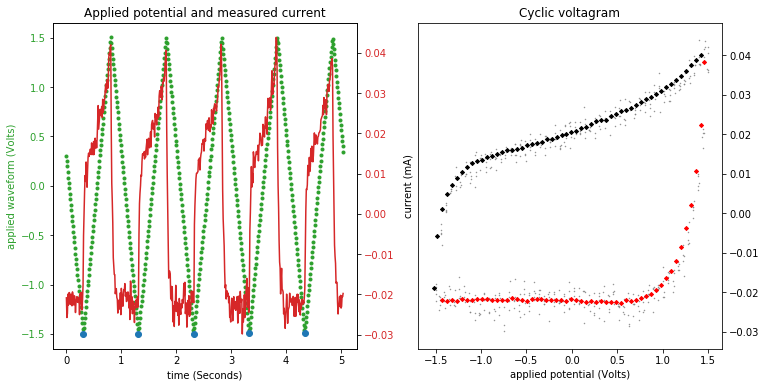

In [4]:
from PDSM_func import AvgWaveForm as awf

tracknumber = 1
real_period = 1 #The applied waveform period in Hz
halfper = 55 # estimate number of recorded frames in half a period, hint: round up

trigfile = mfile.strip(fext) + '_m' + str(tracknumber)+ '.npy'  # trigger file corresponding to each sequence 

trigdata = np.load(fdir+trigfile)
ntrig = np.size(trigdata,0)
print(ntrig, " times triggered")
R_series = 1.008 # serial resistor in kOhm, used for measuring current

scycles = awf.find_potential_cycles(trigdata[:,0], 2*halfper)
period = awf.find_nframes_cycle(scycles)
full_cycles = np.size(scycles) - 1
print('number of complete cycles:', full_cycles)
print(scycles[:10], 'period= ', period)
daq_offset = np.mean(trigdata[:,0])
print('average applied potential:', daq_offset)
cell_potential = np.copy(trigdata[:,0]-daq_offset)
ns = 10 * halfper # choosing the few first cycles for viewing
# plotting the trigger data for overview
avg_potential = awf.avg_potential_cycle(trigdata[:scycles[full_cycles],0], scycles[:full_cycles])
vdrop = trigdata[:scycles[full_cycles],1] - daq_offset
avg_current = awf.avg_potential_cycle(vdrop, scycles[:full_cycles]) / R_series  # current in mA
###Plotting the change of intensity over the sequence
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
color = 'tab:green'

taxis = np.arange(ns)/period * real_period
ax1.set_title("Applied potential and measured current")
ax1.set_xlabel('time (Seconds)')
ax1.set_ylabel('applied waveform (Volts)', color=color)  # we already handled the x-label with ax1
ax1.plot(taxis, cell_potential[:ns], '.',color=color)
ax1.plot(taxis[scycles[:5]], cell_potential[scycles[:5]], 'o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.plot(taxis, (trigdata[:ns,1]- daq_offset)/R_series , color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = plt.subplot(122)
ax3.set_title("Cyclic voltagram")
ax3.scatter(cell_potential[:ns], vdrop[:ns] / R_series, color = 'grey', s=0.2)
ax3.scatter(avg_potential[:halfper], avg_current[:halfper], c = 'k', marker="D", s=8)
ax3.scatter(avg_potential[halfper:], avg_current[halfper:], c = 'r', marker="D", s=8)
ax3.set_xlabel('applied potential (Volts)')
ax3.set_ylabel('current (mA)')
ax3.yaxis.tick_right()

outf = outputdir  + trigfile.strip('.npy') + '_IV.png'
fig.savefig(outf)
outf = outputdir  + trigfile.strip('.npy') + '_IV.npy'
np.save(outf, [avg_potential, avg_current])

### Import recorded image sequence files
- hdf5 files contain several sequences corresponding, each with a different trigger series

In [5]:
# Import HDF5 video sequence:
from PDSM_func import functionsDFSM as dfsm  #functions written and maintained by Kevin 
data = dfsm.ImportHDF5data(fpath)
data.setkey(0)
print("Wherein there is :", data.getkeys())
data.resetkeys()

seq = data[tracknumber,1] #Sanli: what is the second index?
firstline = np.mean(seq[:,20,:], axis=0)
nf = np.size(firstline[firstline >0])
frames = seq[:,:,:nf]
Lx, Ly, nf = frames.shape
print(f"{nf} frames of size {Lx, Ly} in the sequence")

Data in /Users/sanli/Repositories/Data/PDSM_UnderInvestigation/20190723_Crgrid/Crgrid_cell_NaCl10mM_t4.hdf5 :  ['2019-07-23 16:55:51.190000', '2019-07-23 16:58:33.291000', '2019-07-23 17:01:31.850000', '2019-07-23 17:04:12.644000', '2019-07-23 17:06:46.311000']
Wherein there is :  ['metadata', 'timelapse']
Wherein there is : ['metadata', 'timelapse']
18625 frames of size (716, 140) in the sequence


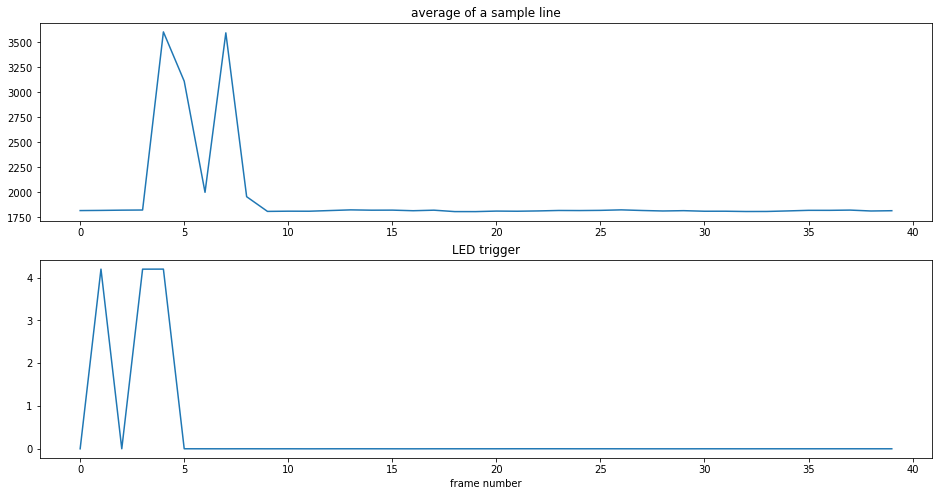

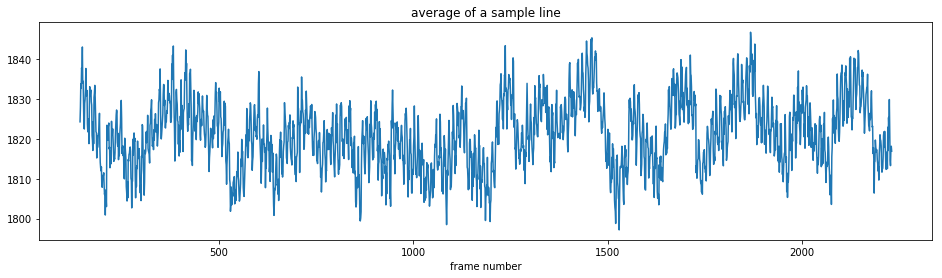

In [6]:
# if not os.path.exists(outputdir):
#     os.makedirs(outputdir)
cyc1, cyc2, cyc11 = scycles[0], scycles[1], scycles[20]  #cyc11 is code name for the last cycle to be considered in this quick check
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot(211)
ax1.plot(firstline[:40])
ax1.set_title("average of a sample line")

ax2 = plt.subplot(212)
ax2.plot(trigdata[:40,2])
ax2.set_title("LED trigger")
ax2.set_xlabel("frame number")
plt.show()

fig2 = plt.figure(figsize=(16,4))
plt.plot(range(cyc2,cyc11),firstline[cyc2:cyc11])
plt.title("average of a sample line")
plt.xlabel("frame number")
plt.show()

previewfile = outputdir + 'singleline_seq' + str(tracknumber) + '.png'
fig2.savefig(previewfile)

### Correct for the delay between images and the recorded triggers
sometimes, due to code execution overhead, there are a few frames delay between recording the voltage and trigger emitted by the camera. This value can be estimated from the triggered frame of the flashed LED.

In [7]:
led_delay = 3
scycles = awf.find_potential_cycles(trigdata[:,0], 2*halfper)
scycles = scycles + led_delay
cyc1, cyc2, cyc11 = scycles[0], scycles[1], scycles[11]
print (cyc1, cyc2, cyc11)
print(scycles[:10])
f= np.mean(scycles[1:]-scycles[:np.size(scycles)-1])
print ('average period = ',f)

36 146 1245
[  36  146  256  366  476  586  696  806  916 1026]
average period =  109.952380952


### Look at the mean intensity and variance over the first 10 cycles
Rules of thumb: to be written!

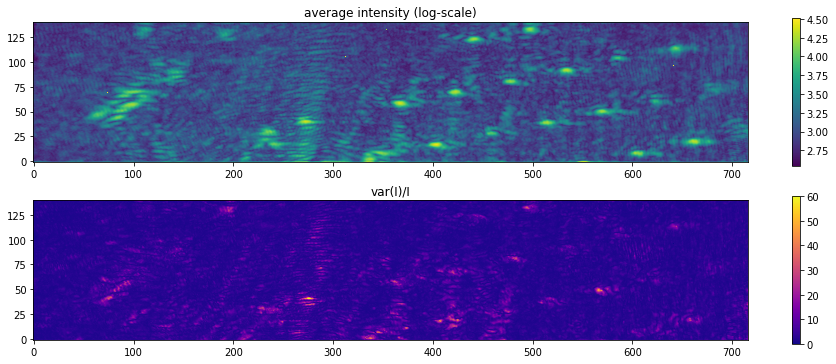

In [8]:
fig = plt.figure(figsize=(16,6))
ax1 = plt.subplot(211)
darkcounts = 100
mean_img = np.mean(frames[:,:,cyc1:cyc11],axis=2) - darkcounts
im = ax1.imshow(np.transpose(np.log10(mean_img)), origin ='lower')
plt.colorbar(im, ax = ax1)
plt.title("average intensity (log-scale)")

ax2 = plt.subplot(212)
var_img = np.var(frames[:,:,cyc1:cyc11],axis=2)
im = ax2.imshow(np.transpose(var_img/mean_img), vmax=60, cmap='plasma', origin ='lower')
plt.colorbar(im, ax = ax2)
plt.title('var(I)/I')

plt.show()
previewfile = outputdir + mfile.strip(fext)+'_var'
fig.savefig(previewfile)

### Find the harmonic pattern

Using the potential variation as the reference curve, we calculate the average correlation with that on each spot. This will increase the contrast of points that have a different response than the background

alpha = <(I(t) - <I>)*V(t)> / < V^2 > , where < f > means averaging over all frames. 
    
The out of sync harmonic component is defined:
beta = <(I(t) - V * alpha) * V> / < V^2 >
    
to correct for drift, the average <I>  is calculated only for the each period

IntProgress(value=0, max=30)

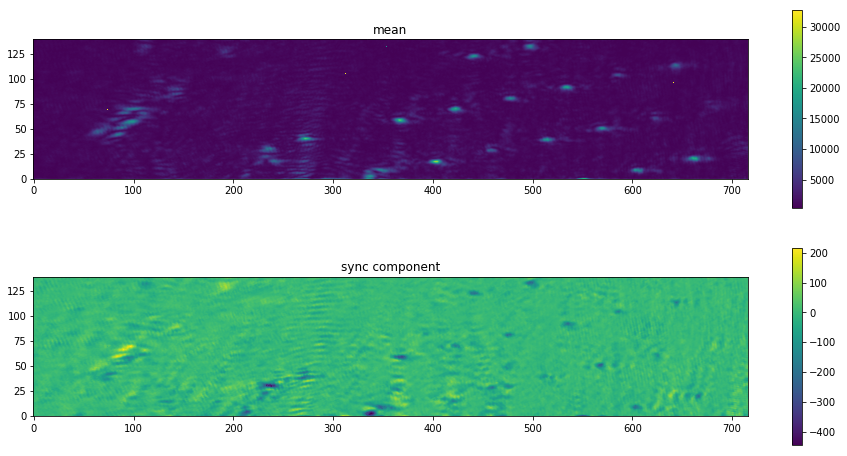

In [45]:
ncyc = 30  # change to full_cycles for complete video

f = IntProgress(min=0, max=ncyc) # instantiate the bar
display(f) # display the bar

this_cycle = np.zeros([Lx, Ly])
off_cycle = np.zeros([Lx, Ly])

sync_average = np.zeros([Lx, Ly])
sync_w = cell_potential[cyc2-led_delay:cyc2-led_delay+period+1]
async_average = np.zeros([Lx, Ly])
# qp = np.int(period/4)
# async_w = cell_potential[cyc2-qp:cyc2+period-qp+1]
for i in range(ncyc):
    f.value = i+1
    for x in range(Lx):
        for y in range(Ly):
            cr = np.cov(frames[x,y,scycles[i]:scycles[i]+period+1], sync_w)
            this_cycle[x,y] = cr[0,1] / cr[1,1] 
    sync_average = sync_average + this_cycle/ncyc

fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot(211)
im = ax1.imshow(np.transpose((mean_img)), origin ='lower')
plt.colorbar(im, ax = ax1)
ax1.set_title("mean")

ax2 = plt.subplot(212)
im = ax2.imshow(np.transpose((sync_average)), origin ='lower')
plt.colorbar(im, ax = ax2)
ax2.set_title("sync component")



plt.show()


### Find some spots that correspond to particle and calcualte the I vs V average

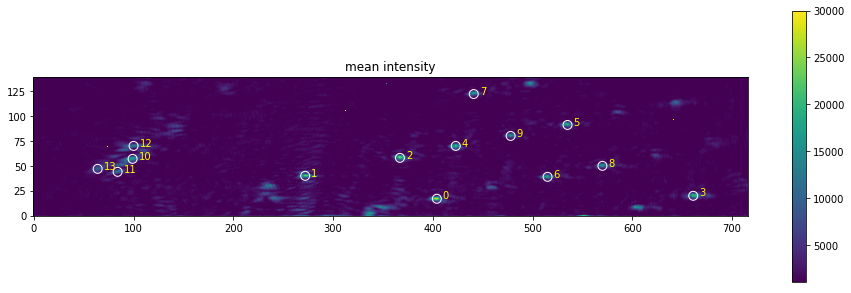

In [47]:
nspots = 14

spotmap = np.copy(mean_img)
# spotmap_alt = np.copy(first_harmonic/mean_img)  #an alternative way of chosing interesting spots

spots = []
cx, cy = 250, 0  # separation between ITO region and dots
wx, wy = 18, 10  #minimum separation between interesting spots
selminmarg = spotmap[cx+wx:Lx-wx-1, cy+wy:Ly-wy-1] #used to make sure chosen speckle spots are completely inside
selminmarg_ito = spotmap[wx:cx-wx-1, wy:cy-wy-1]

spotmap[spotmap > 3.2e4] = 0  # to remove single saturated pixels

for i in range(nspots):
    if i <10:
        mx, my = np.unravel_index(np.argmax(selminmarg), selminmarg.shape)    
        mx = mx + cx + wx
        my = my + cy + wy
    else:
        mx, my = np.unravel_index(np.argmax(selminmarg_ito), selminmarg_ito.shape)    
        mx = mx + wx
        my = my + wy
        
    spots = numpy.concatenate((spots, [mx, my, mean_img[mx, my]]), axis=0)
    spotmap[mx-wx:mx+wx, my-wy:my+wy] = 0 * spotmap[mx-wx:mx+wx, my-wy:my+wy]
    
spots = spots.reshape(nspots,3)
# print(spots)

fig = plt.figure(figsize=(16,5))
ax1 = plt.subplot(111)
im = ax1.imshow(np.transpose(mean_img), vmin = 30000, vmax = 1000,origin ='lower')
plt.colorbar(im, ax = ax1)
ax1.set_title("mean intensity")

#mark spot positions
ax1.scatter(spots[:,0], spots[:,1], s=80, facecolors='none', edgecolors='w')
for i in range(nspots):
    ax1.annotate(str(i), (spots[i,0]+6, spots[i,1]), color='yellow')
plt.show()
previewfile = outputdir + mfile.strip(fext)+ '_seq' + str(tracknumber) + '_spotmap.png'
fig.savefig(previewfile)

output = outputdir + mfile.strip(fext)+ '_seq' + str(tracknumber) +'_spotxy.npy'
np.save(output, spots)

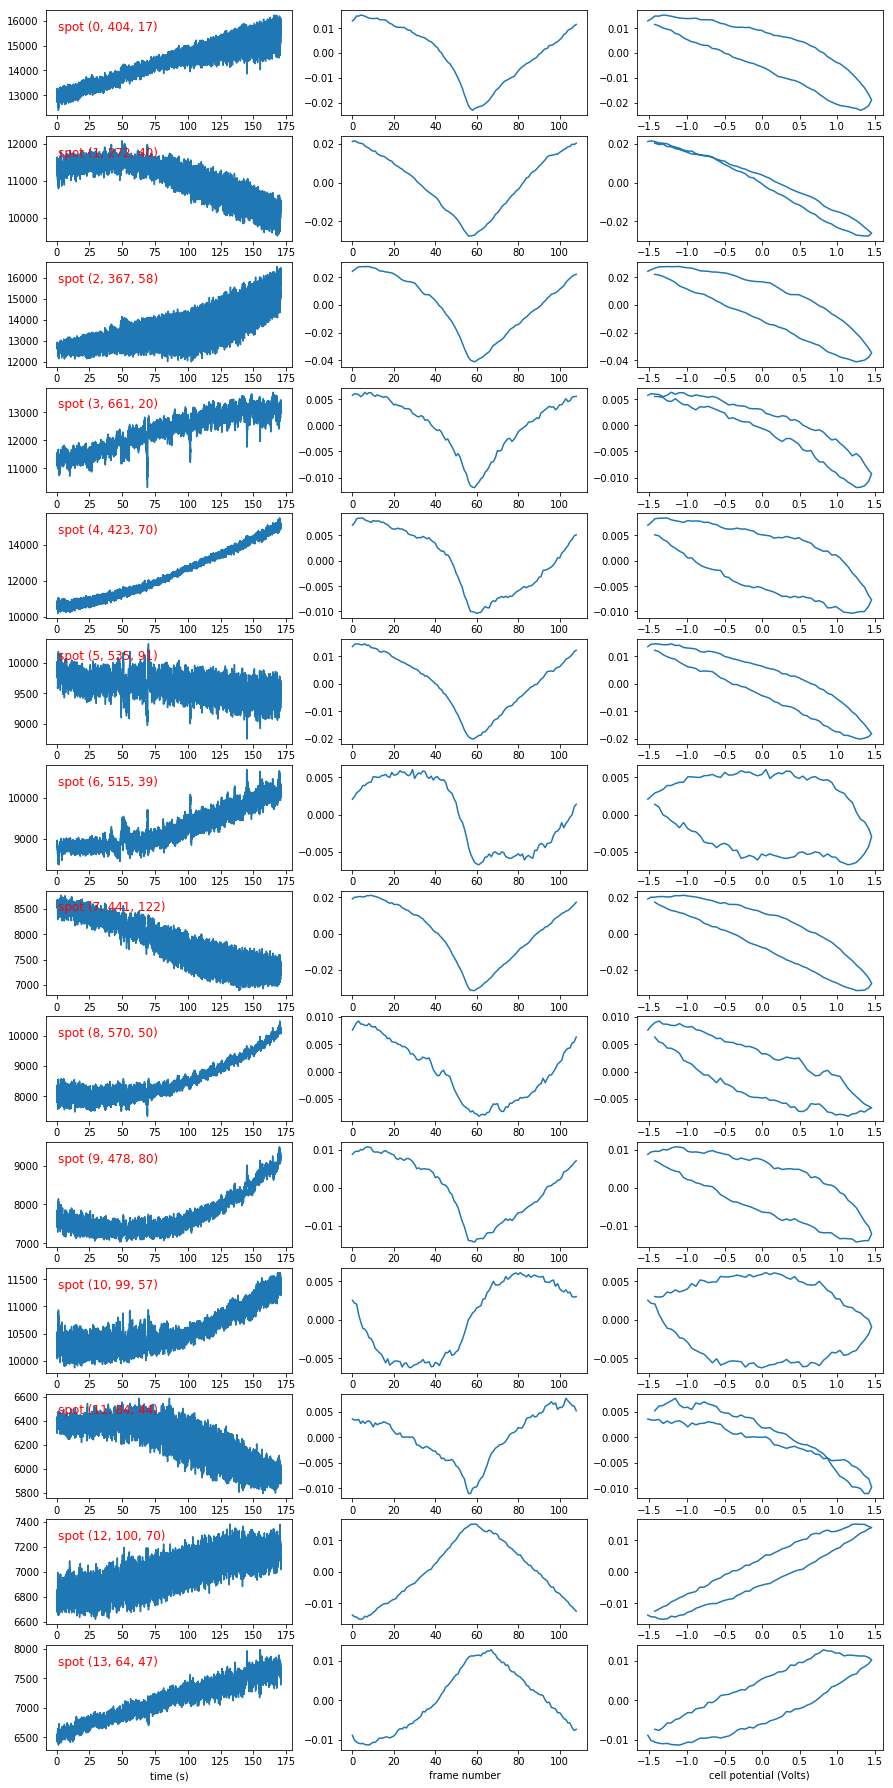

(15, 109)


In [48]:
wx, wy = 3, 3  #size of speckle spot considered as one point

# nspots = 10
row, col = nspots, 3
fig = plt.figure(figsize=(15,32))
taxis = real_period * np.arange(cyc1,nf)/period
voltagram = [np.copy(avg_potential)]
for i in range(nspots):
    mx, my = int(spots[i,0]), int(spots[i,1])
    spot = np.mean(np.mean(frames[mx-wx:mx+wx+1, my-wy:my+wy+1, :] - darkcounts, axis=0), axis=0)
    ax1 = plt.subplot(row, col, 3*i+1)
    ax1.plot(taxis, spot[cyc1:])
    ax1.text(0.05,0.9, f"spot {(i, mx, my)}", transform=ax1.transAxes, fontsize=12, color = 'red', va='top')
    avg_di = awf.avg_intensity_cycle(spot, scycles)/np.mean(spot[cyc1:])
    voltagram = numpy.concatenate([voltagram, [avg_di]], axis=0)
    ax2 = plt.subplot(row, col, 3*i+2)
    ax2.plot(avg_di)    
    ax3 = plt.subplot(row, col, 3*i+3)
    ax3.plot(avg_potential, avg_di)
    
    
ax1.set_xlabel('time (s)')
ax2.set_xlabel('frame number')
ax3.set_xlabel('cell potential (Volts)')
    
plt.show()  
print(voltagram.shape)
output = outputdir + mfile.strip(fext) + '_seq' + str(tracknumber) +'_spots.png'
fig.savefig(output)

output = outputdir + mfile.strip(fext)+ '_seq' + str(tracknumber) +'_cycavg.npy'
np.save(output, voltagram)

### Calculate the synchronous component
This is a direct way of estimating the average signal that changes in sync with the voltage. We define tha sync component alpha as:  

alpha = <(I(t) - <I>)*V(t)> / < V^2 > , where < f > means averaging over all frames. 
    
The out of sync harmonic component is defined:
beta = <(I(t) - V * alpha) * V> / < V^2 >
    
to correct for drift, the average <I>  is calculated only for the each period

IntProgress(value=0, max=166)

NameError: name 'darkcount' is not defined

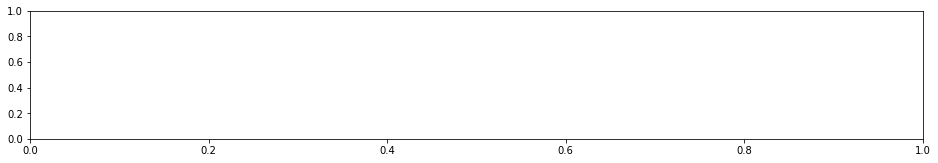

In [52]:
ncyc = full_cycles -2  # change to full_cycles for complete video
ref_spot = 5
ito_spot = 12
period = voltagram.shape[1]
pbar = IntProgress(min=0, max=ncyc) # instantiate the bar
display(pbar) # display the bar

this_cycle = np.zeros([Lx, Ly])
ito_cycle = np.zeros([Lx, Ly])

sync_average = np.zeros([Lx, Ly])
ito_correlate = np.zeros([Lx, Ly])

sync_w = voltagram[ref_spot+1,:]
sync_ito = voltagram[ito_spot+1,:]

for i in range(ncyc):
    pbar.value = i+1
    for x in range(Lx):
        for y in range(Ly):
            cr = np.cov(frames[x,y,scycles[i]:scycles[i]+period], sync_w)
            this_cycle[x,y] = cr[0,1] / cr[1,1] 
            cri = np.cov(frames[x,y,scycles[i]:scycles[i]+period], sync_ito)
            ito_cycle[x,y] = cri[0,1] / cri[1,1] 
    sync_average = sync_average + this_cycle/ncyc
    ito_correlate = ito_correlate + ito_cycle/ncyc

    
varI = np.var(mean_img)

fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot(311)
im = ax1.imshow(np.transpose(mean_img - darkcounts), cmap = 'gray', origin ='lower')
plt.colorbar(im, ax = ax1)
ax1.set_title("mean intensity")
ax1.scatter(spots[ref_spot,0], spots[ref_spot,1], s=80, facecolors='none', edgecolors='w')
ax1.annotate(str(ref_spot), (spots[ref_spot,0]+6, spots[ref_spot,1]), color='yellow')
ax1.scatter(spots[ito_spot,0], spots[ito_spot,1], s=80, facecolors='none', edgecolors='g')
ax1.annotate(str(ito_spot), (spots[ito_spot,0]+6, spots[ito_spot,1]), color='yellow')


ax2 = plt.subplot(312)
im = ax2.imshow(np.transpose(sync_average/varI), vmin = -0.01, vmax = 0.01, cmap = 'plasma', origin ='lower')
plt.colorbar(im, ax = ax2)
ax2.set_title(f"sync with spot {ref_spot}")

ax3 = plt.subplot(313)
im = ax3.imshow(np.transpose(ito_correlate/varI), vmin = -0.01, vmax = 0.01, cmap = 'plasma', origin ='lower')
plt.colorbar(im, ax = ax3)
ax3.set_title("sync with ito")

plt.show()

output = outputdir + mfile.strip(fext) + '_seq' + str(tracknumber) + f'_spot' + str(ref_spot) + '_corr.png'
fig.savefig(output)

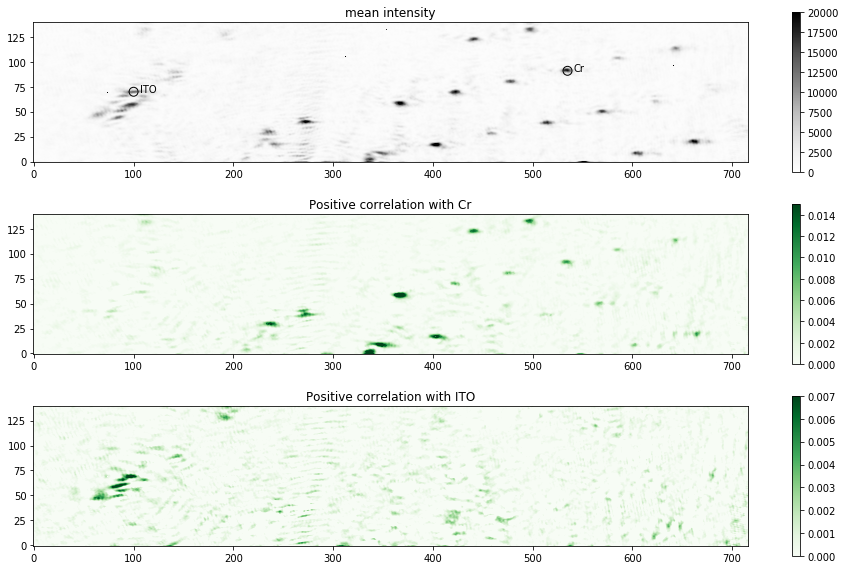

In [65]:
fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot(311)
im = ax1.imshow(np.transpose(mean_img - darkcounts), vmin = 0.0, vmax =20000, cmap = 'Greys', origin ='lower')
plt.colorbar(im, ax = ax1)
ax1.set_title("mean intensity")
ax1.scatter(spots[ref_spot,0], spots[ref_spot,1], s=80, facecolors='none', edgecolors='k')
ax1.annotate('Cr', (spots[ref_spot,0]+6, spots[ref_spot,1]), color='k')
ax1.scatter(spots[ito_spot,0], spots[ito_spot,1], s=80, facecolors='none', edgecolors='k')
ax1.annotate('ITO', (spots[ito_spot,0]+6, spots[ito_spot,1]), color='k')


ax2 = plt.subplot(312)
im = ax2.imshow(np.transpose(sync_average/varI), vmin = -0.0, vmax =0.015, cmap = 'Greens', origin ='lower')
plt.colorbar(im, ax = ax2)
ax2.set_title(f"Positive correlation with Cr")

ax3 = plt.subplot(313)
im = ax3.imshow(np.transpose(ito_correlate/varI), vmin = -0.0, vmax =0.007, cmap = 'Greens', origin ='lower')
plt.colorbar(im, ax = ax3)
ax3.set_title("Positive correlation with ITO")

plt.show()

output = outputdir + mfile.strip(fext) + '_seq' + str(tracknumber) + f'_spot' + str(ref_spot) + '_corr_pos_greens.png'
fig.savefig(output)

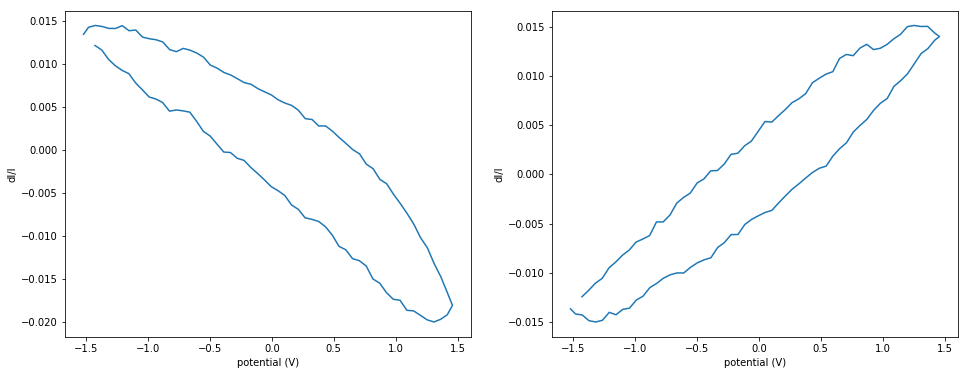

In [70]:
fig = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
ax1.plot(voltagram[0,:], sync_w)
ax2 = plt.subplot(122)
ax2.plot(voltagram[0,:], sync_ito)
ax1.set_xlabel('potential (V)')
ax2.set_xlabel('potential (V)')
ax2.set_ylabel('dI/I')
ax1.set_ylabel('dI/I')
plt.show()
output = outputdir + mfile.strip(fext) + '_seq' + str(tracknumber) + '_ref_spots_cyclic.png'
fig.savefig(output)